# Assignment Two


# Time Series Analysis of Daily Steps Data

Author: **Chadrack Kavula Mulamba**  
Date: **20 August 2023**      
Github url: **https://github.com/chadrack-123/TImeSeriesData**  

### Importing dependencies

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error, r2_score
register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model.ARIMA import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from time import time
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Next we are going to import, clean, and plot the time series data

### Step 1 Data Preparation

#### Extract-Transform-Load

##### First of all we need to combine all 15 csv files into one data frame

In [2]:
# List all CSV files in the directory
csv_files = ['Steps1.csv','Steps2.csv','Steps3.csv','Steps4.csv','Steps5.csv','Steps6.csv','Steps7.csv','Steps8.csv','Steps9.csv','Steps10.csv','Steps11.csv','Steps12.csv','Steps13.csv','Steps14.csv','Steps15.csv']

# Initialize an empty DataFrame to hold the combined data
combined_fitness_data = pd.DataFrame()

# Loop through each CSV file and append its data to the combined DataFrame
for file in csv_files:
    data = pd.read_csv(file)
    combined_fitness_data = combined_fitness_data.append(data, ignore_index=True)


#combined_fitness_data.to_csv('combined.csv')

#### Converting "Date" column to datetime format

In [3]:
# Convert "Date" column to datetime format
combined_fitness_data["Date"] = pd.to_datetime(combined_fitness_data["Date"])

#### Set the index to the "Date" column

In [4]:
# Set the index to the "Date" column
combined_fitness_data.set_index("Date", inplace=True)

#### Handling missing values

In [5]:
# Fill missing values with the mean of the column
combined_fitness_data.fillna(combined_fitness_data.mean(), inplace=True)


<p> Now our data is called combined_fitness_data </p>

### Let's view the data

In [6]:
combined_fitness_data.head()

,Actual,Goal
Date,,
2022-05-31,0,8000
2022-06-01,0,8000
2022-06-02,0,8000
2022-06-03,1102,8000
2022-06-04,1254,8000


In [7]:
combined_fitness_data

,Actual,Goal
Date,,
2022-05-31,0,8000
2022-06-01,0,8000
2022-06-02,0,8000
2022-06-03,1102,8000
2022-06-04,1254,8000
...,...,...
2023-07-20,8393,6500
2023-07-21,5954,6500
2023-07-22,9550,6500


In [8]:
combined_fitness_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2022-05-31 to 2023-07-24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Actual  420 non-null    int64
 1   Goal    420 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


In [9]:
combined_fitness_data.isnull().sum()

Actual    0
Goal      0
dtype: int64

<p> No missing values the dataset is ready to be used for analysis </p>

### Step 2 Exploratory Data Analysis (EDA)

#### Visualizing the time series data

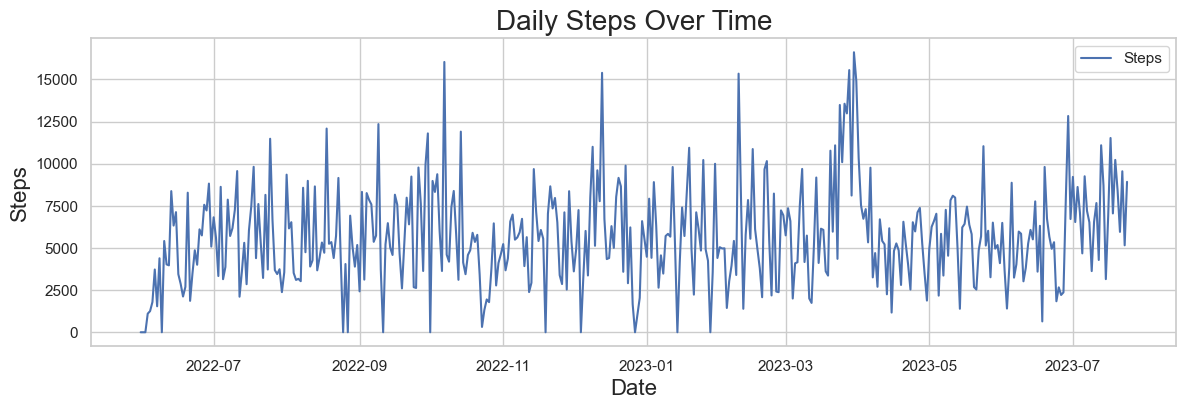

In [10]:
# Visualize time series
plt.figure(figsize=(14, 4))
plt.plot(combined_fitness_data["Actual"], label="Steps")
plt.title("Daily Steps Over Time", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Steps", fontsize=16)
plt.legend()
plt.show()

<p> First impressions, there is a definite trend and seasonality in the data </p>

#### Calculating descriptive statistics

In [11]:
# Calculate descriptive statistics
mean_steps = combined_fitness_data["Actual"].mean()
median_steps = combined_fitness_data["Actual"].median()
std_steps = combined_fitness_data["Actual"].std()
print("Mean:", mean_steps)
print("Median:", median_steps)
print("Standard Deviation:", std_steps)

Mean: 5674.140476190476
Median: 5402.0
Standard Deviation: 2930.565438900008


In [12]:
combined_fitness_data["Actual"].describe()

count      420.000000
mean      5674.140476
std       2930.565439
min          0.000000
25%       3634.000000
50%       5402.000000
75%       7349.000000
max      16611.000000
Name: Actual, dtype: float64

### Step 3 Test for seasonality and if the data is stationary

#### Let's do STL decomposition

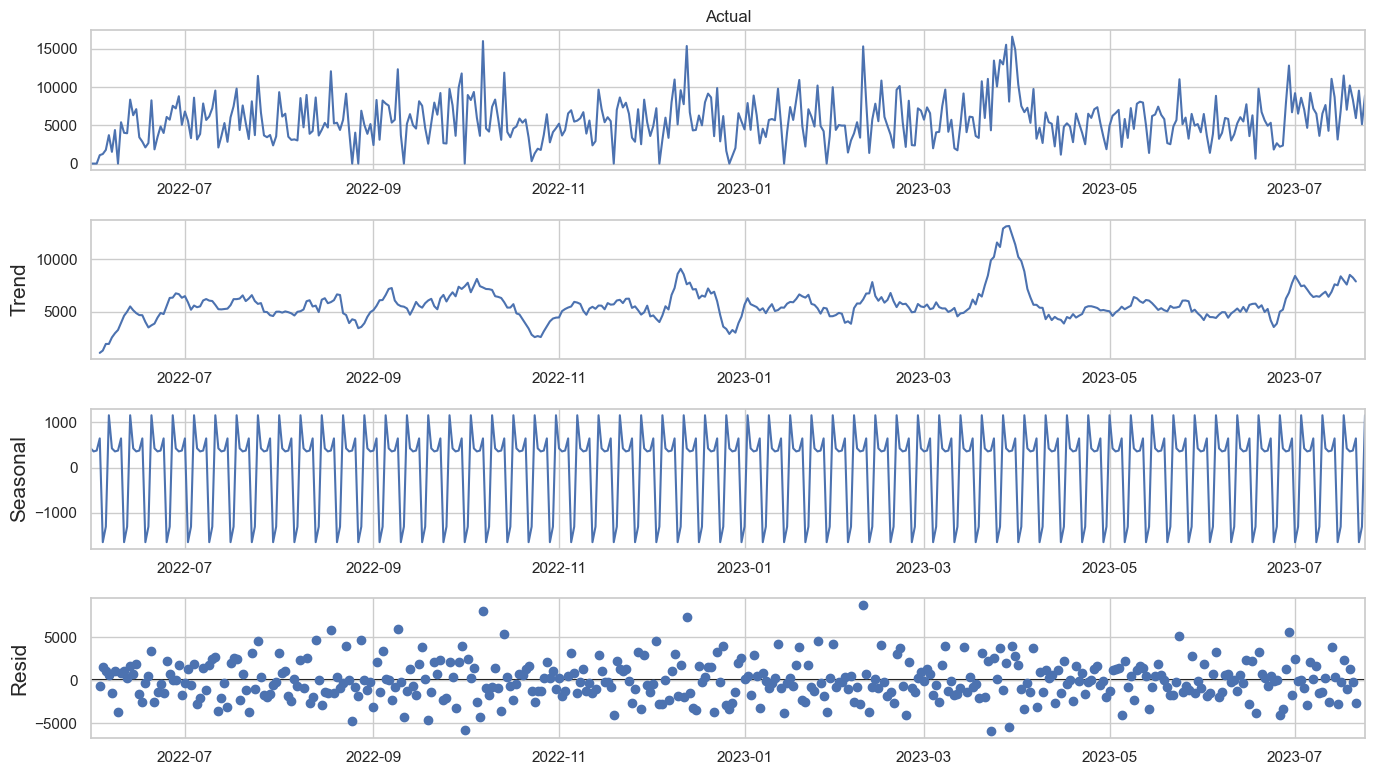

In [13]:

plt.rc('figure',figsize=(14,8))
plt.rc('font', size = 15)
# Perform seasonal decomposition
result = seasonal_decompose(combined_fitness_data['Actual'], model='additive')

# Plot decomposed components
fig = result.plot()

#### Points to consider  

<p>1. There is a visible 7 days seasonal pattern <br>   
2. The trend is evidently fluactuating </p>

#### Performing Augmented Dickey-Fuller test

In [14]:
#Perform Dickey-fuller test

print("Results of Dickey-Fuller Test:")
dftest = adfuller(combined_fitness_data["Actual"], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.831054
p-value                         0.000047
#Lags Used                     13.000000
Number of Observation Used    406.000000
Critical Value (1%)            -3.446560
Critical Value (5%)            -2.868685
Critical Value (10%)           -2.570576
dtype: float64


<p>Based on these results, it seems that the time series data is <b>stationary</b>, since the ADF statistic is -4.83 and the p-value is  0.000047 (very close to zero). This is an important consideration for many time series analyses and forecasting techniques, as they often assume to work better with stationary data.</p>

### Step 4 Model selection

<p> Since the time series data is stationary, ARIMA will be the model to start with to fit the prediction to the model.

<p>Let's look at ACF and PACF plots to get an idea for p and q values</p>

#### ACF and PACF plots to estimate p and q value

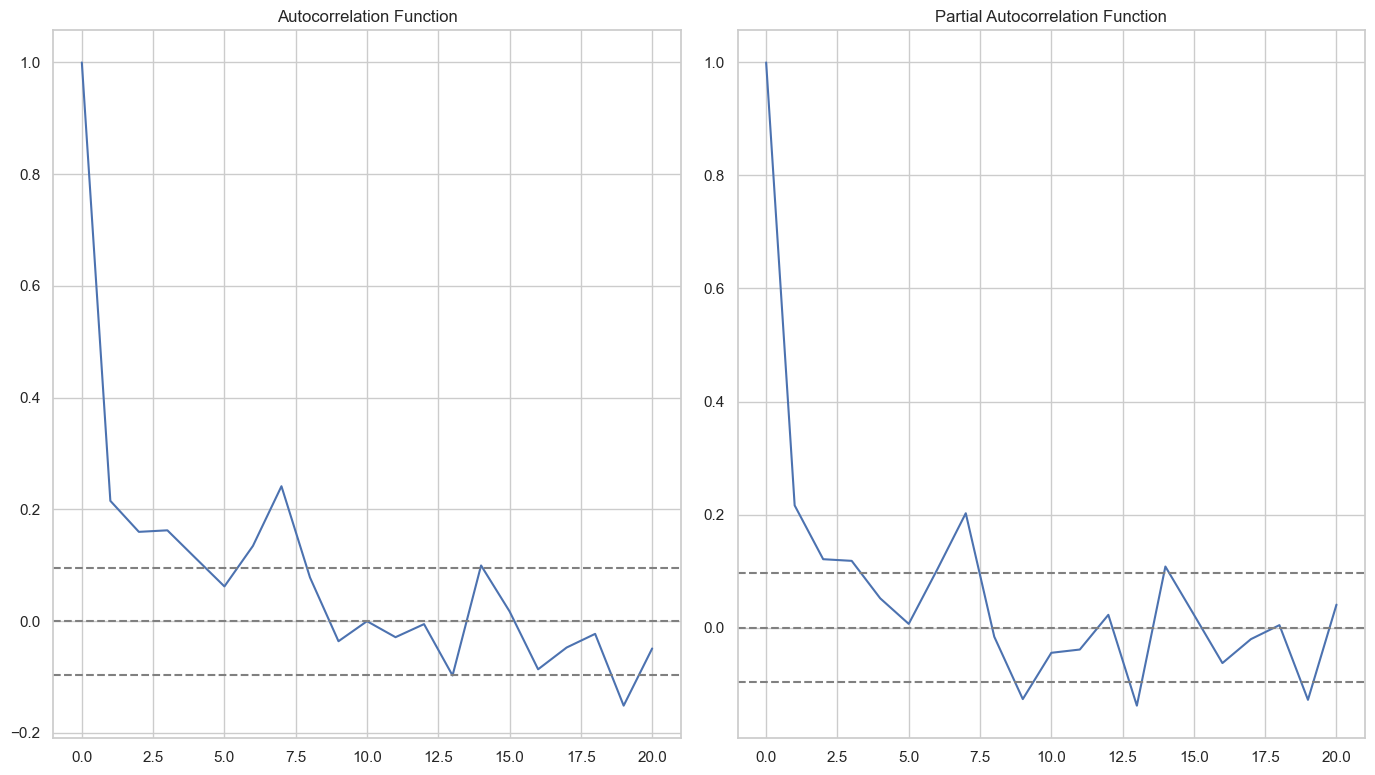

In [15]:
#ACF and PACF plots:

lag_acf = acf(combined_fitness_data["Actual"], nlags = 20)
lag_pacf = pacf(combined_fitness_data["Actual"], nlags = 20, method ='ols')

#Plot ACF: for the value of q
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(combined_fitness_data["Actual"])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(combined_fitness_data["Actual"])), linestyle='--', color='gray')
plt.title("Autocorrelation Function")


#Plot PACF: for the value of p
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(combined_fitness_data["Actual"])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(combined_fitness_data["Actual"])), linestyle='--', color='gray')
plt.title("Partial Autocorrelation Function")

plt.tight_layout()



<Figure size 1200x600 with 0 Axes>

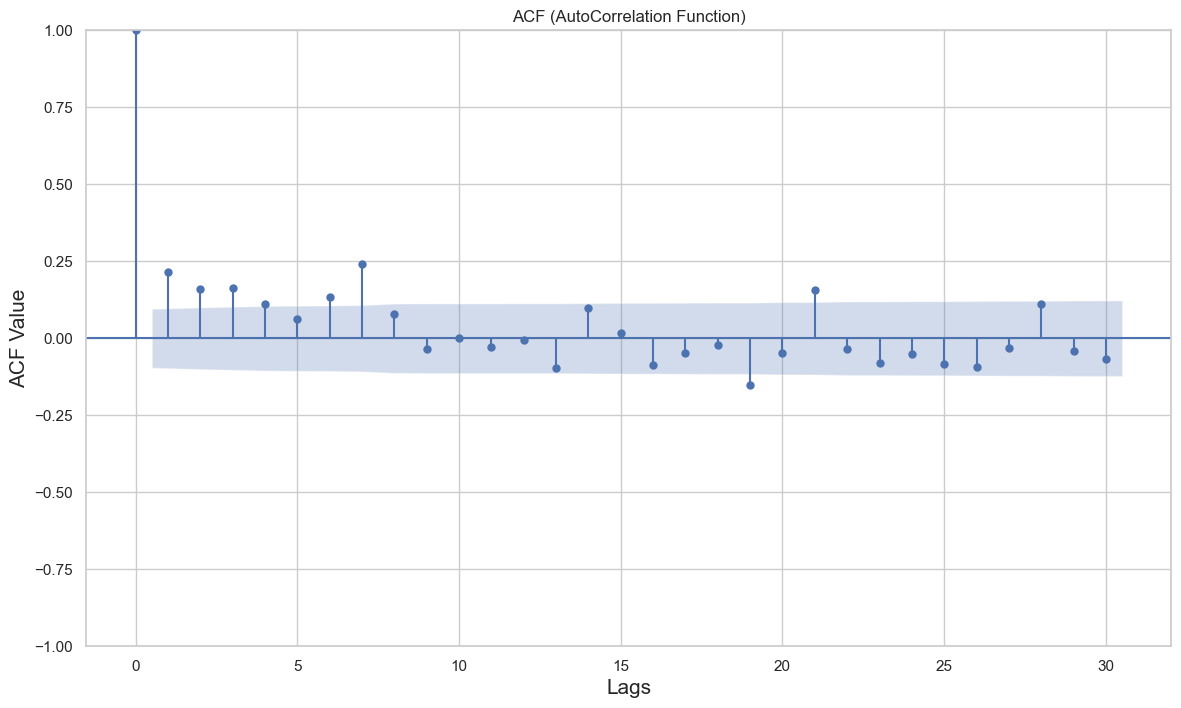

<Figure size 1200x600 with 0 Axes>

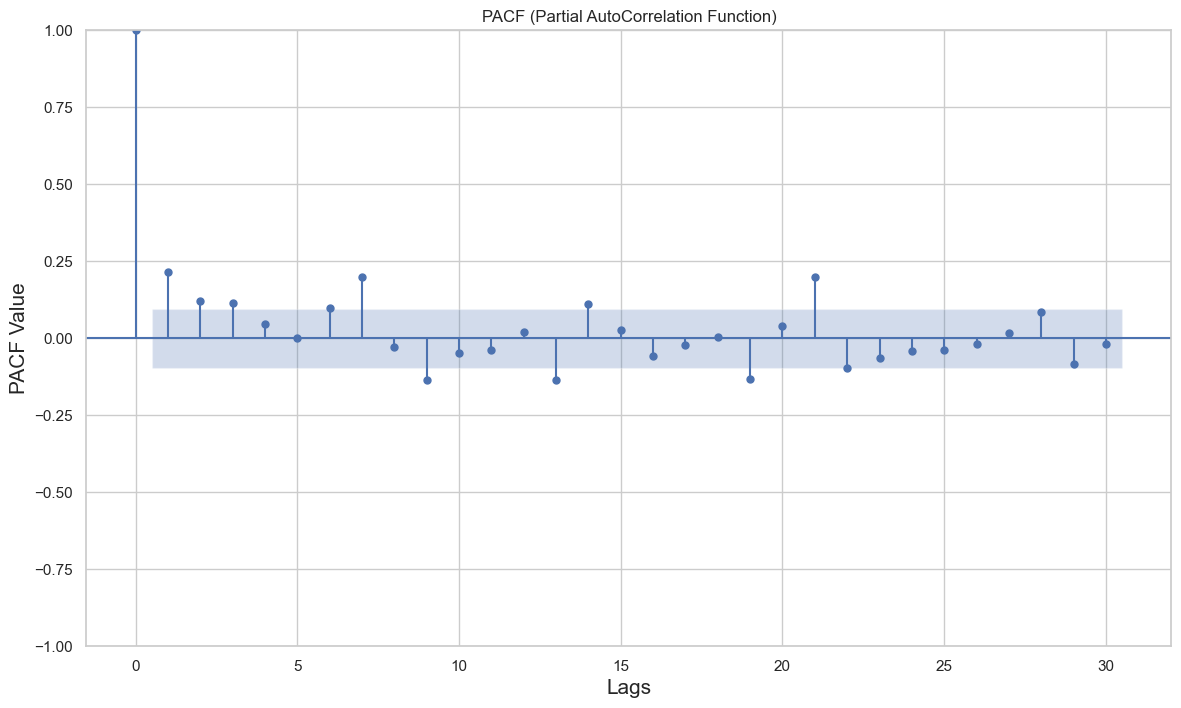

In [16]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(combined_fitness_data["Actual"], lags=30, alpha=0.05)
plt.title("ACF (AutoCorrelation Function)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(combined_fitness_data["Actual"], lags=30, alpha=0.05)
plt.title("PACF (Partial AutoCorrelation Function)")
plt.xlabel("Lags")
plt.ylabel("PACF Value")
plt.show()

<p>The value of q can be 1, 2, 3, and 4 <br> The value of p can be 1, 2, and 3</p>

#### Fitting ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA
p = 2  # Specify the order of the auto-regressive component
d = 0  # Since the data is stationary, no differencing is needed
q = 4  # Specify the order of the moving average component

arima_model = ARIMA(combined_fitness_data["Actual"], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Print model summary
print(arima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Actual   No. Observations:                  420
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -3923.912
Date:                Sat, 19 Aug 2023   AIC                           7863.824
Time:                        23:41:49   BIC                           7896.146
Sample:                    05-31-2022   HQIC                          7876.599
                         - 07-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5674.1397    194.626     29.154      0.000    5292.680    6055.600
ar.L1         -0.4499      0.007    -67.345      0.000      -0.463      -0.437
ar.L2         -0.9995      0.003   -362.916      0.0

plotting MA model


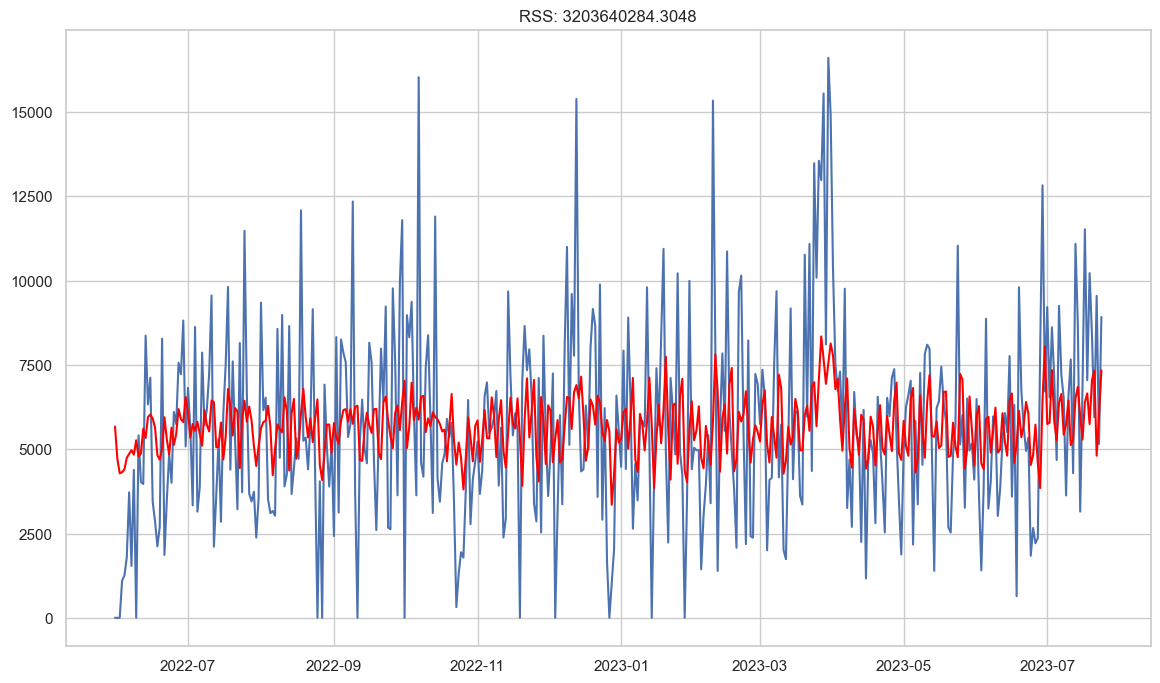

In [18]:

plt.plot(combined_fitness_data["Actual"])
plt.plot(arima_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((arima_model_fit.fittedvalues - combined_fitness_data["Actual"]) **2))
print("plotting MA model")

<p>The model struglled to fit at the begining but it had managed to catch the curves at the end well.</p>

### Step 5 Forcasting

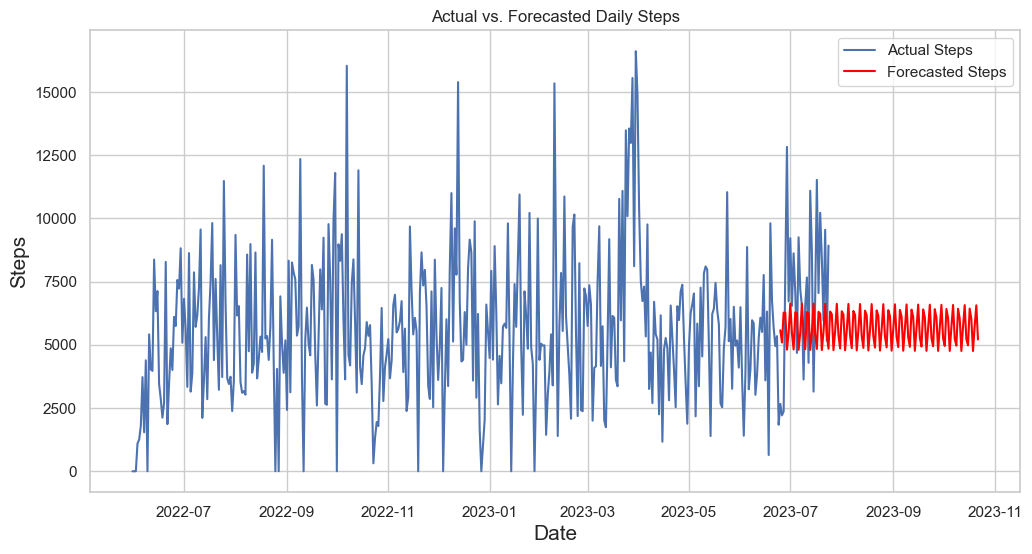

In [19]:
# Define forecasting start date
forecast_start = datetime(2023, 6, 25)


forecast_length = 120
# Forecast steps
forecast_steps = arima_model_fit.get_forecast(steps=forecast_length) 
forecast_index = pd.date_range(forecast_start, periods=forecast_length)

# Plot actual vs. forecasted steps
plt.figure(figsize=(12, 6))
plt.plot(combined_fitness_data["Actual"].index, combined_fitness_data["Actual"], label="Actual Steps")
plt.plot(forecast_index, forecast_steps.predicted_mean, label="Forecasted Steps", color="red")
plt.title("Actual vs. Forecasted Daily Steps")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.legend()
plt.show()




<p>Voila, we predicted the number of steps.</p>

#### Another way of predicting

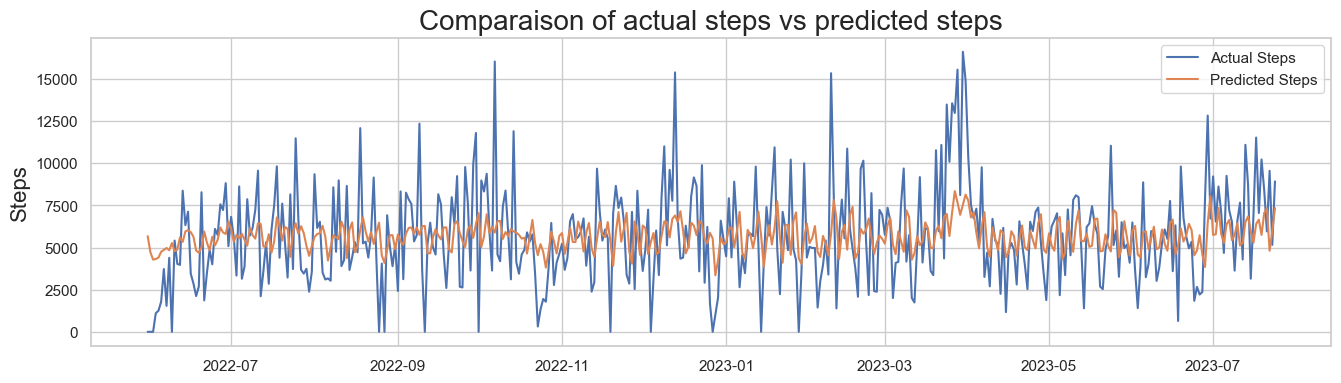

In [20]:
predictions = arima_model.fit().predict()

plt.figure(figsize=(16,4))
plt.plot(combined_fitness_data['Actual'], label ='Actual Steps')
plt.plot(predictions, label='Predicted Steps')
plt.title('Comparaison of actual steps vs predicted steps', fontsize=20)
plt.ylabel('Steps', fontsize=16)
plt.legend()

<p>The model fits just okay</p>

In [21]:
train_size = int(len(combined_fitness_data['Actual']) * 0.8)
train_data, test_data = combined_fitness_data['Actual'][:train_size], combined_fitness_data['Actual'][train_size:]

In [22]:
forecasts = arima_model_fit.forecast(steps=len(test_data))


In [23]:
#Calculating the mean squared error and the rsquared
mse = mean_squared_error(test_data, forecasts)
r2 = r2_score(test_data, forecasts)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5823701.13988214
R-squared: 0.05381553285545626


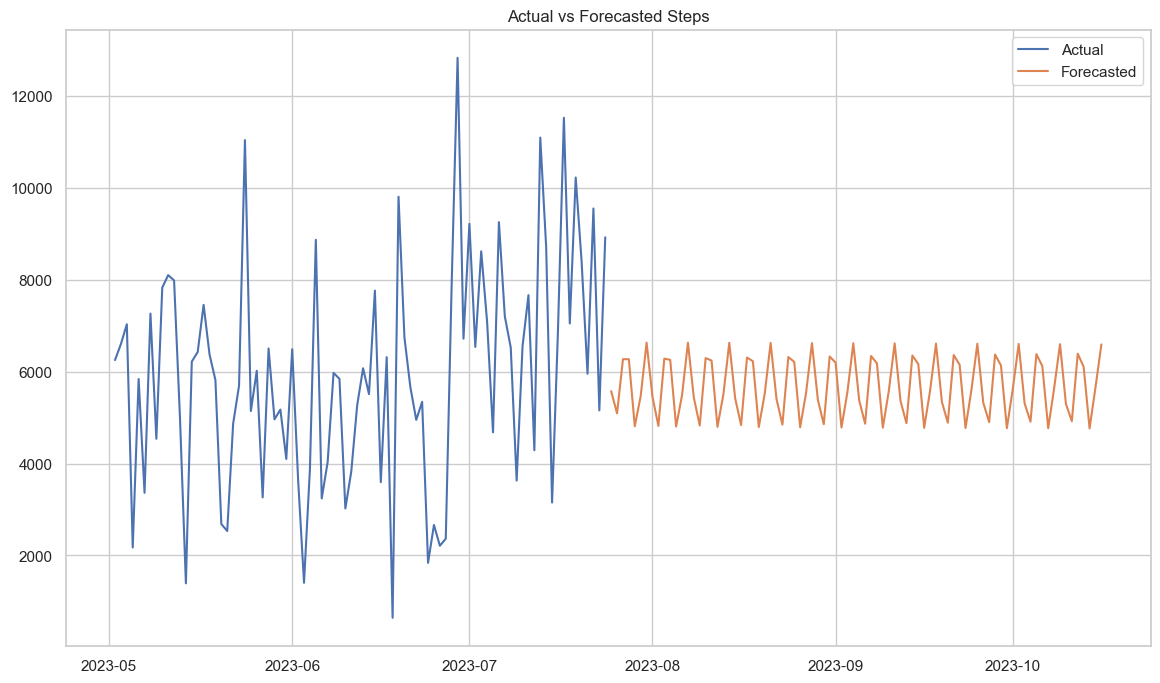

In [24]:
plt.plot(test_data, label='Actual')
plt.plot(forecasts, label='Forecasted')
plt.legend()
plt.title('Actual vs Forecasted Steps')
plt.show()

### Fitting SARIMA to account for seasonality

In [25]:

seasonal_order = (2, 0, 4, 7) 
order = (2, 0, 4)

sarima_model = SARIMAX(combined_fitness_data["Actual"], order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=0)


# Print model summary
print(sarima_model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            Actual   No. Observations:                  420
Model:             SARIMAX(2, 0, 4)x(2, 0, 4, 7)   Log Likelihood               -3911.814
Date:                           Sat, 19 Aug 2023   AIC                           7849.629
Time:                                   23:42:06   BIC                           7902.152
Sample:                               05-31-2022   HQIC                          7870.388
                                    - 07-24-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6450      0.853      1.928      0.054      -0.028       3.318
ar.L2         -0.6568      0.812     -0.808

plotting SARIMA model


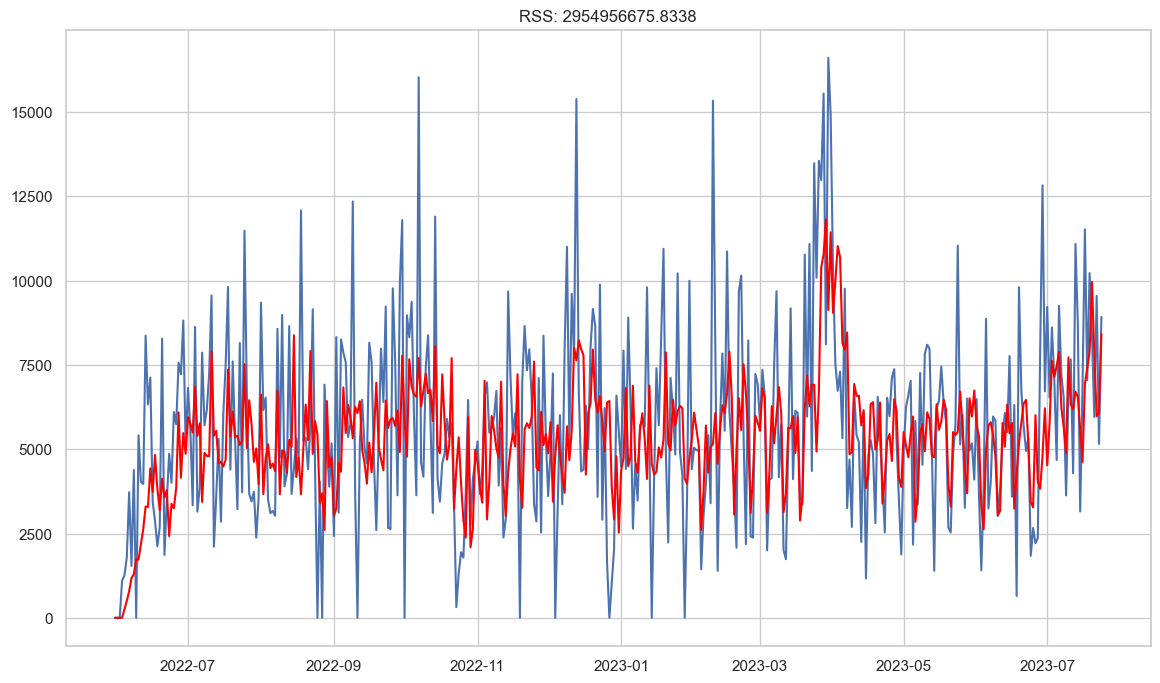

In [26]:

plt.plot(combined_fitness_data["Actual"])
plt.plot(sarima_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((sarima_model_fit.fittedvalues - combined_fitness_data["Actual"]) **2))
print("plotting SARIMA model")

#### Predicting

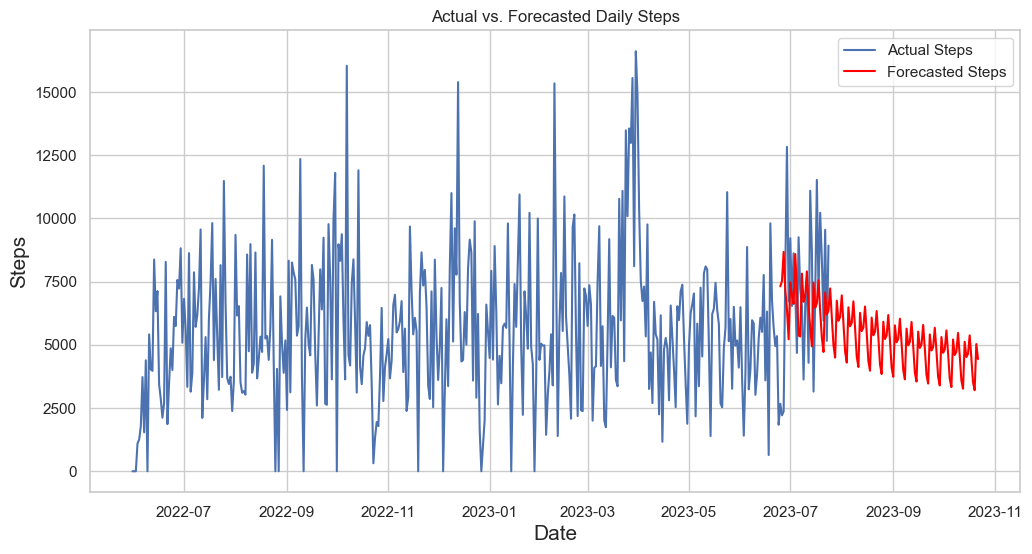

Mean Squared Error (MSE): 6288795.546730401
R-squared (R2): -0.021748973795126414


In [27]:
# Define forecasting start date
forecast_start = datetime(2023, 6, 25)
forecast_length = 120

# Forecast steps
forecast_steps = sarima_model_fit.get_forecast(steps=forecast_length) 
forecast_index = pd.date_range(forecast_start, periods=forecast_length)

sarima_forecasts = sarima_model_fit.get_forecast(steps=len(test_data))

# Plot actual vs. forecasted steps
plt.figure(figsize=(12, 6))
plt.plot(combined_fitness_data["Actual"].index, combined_fitness_data["Actual"], label="Actual Steps")
plt.plot(forecast_index, forecast_steps.predicted_mean, label="Forecasted Steps", color="red")
plt.title("Actual vs. Forecasted Daily Steps")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.legend()
plt.show()



mse = mean_squared_error(test_data, sarima_forecasts.predicted_mean)
r2 = r2_score(test_data, sarima_forecasts.predicted_mean)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

### Step 6 Reflection 

1. **Decision-Making Process:**
my decision process was mainly influenced by the time series data; after checking for stationariness, I
found out that the data is stationary.
-Choice of ARIMA: I first went with ARIMA even though the data has seasonal component. Suprisingly
the model fit well and was able to predict with a good RSS. However, the RSS is very high above 0.
- Choice of SARIMA: I then opted for a Seasonal ARIMA (SARIMA) model because the data has a
seasonal component (steps could vary with the time of year), and SARIMA is well-suited for such data.
- Data Splitting: I split the data into training and testing sets to ensure the model's performance is
evaluated on unseen data.
- Model Parameter Selection: I selected ARIMA orders (p, d, q) based on ACF and PACF. SARIMA
orders (p, d, q, P, D, Q, s) based on domain knowledge or experimentation, aiming for the best balance of
accuracy and model complexity.
- Metric Selection: I chose Mean Squared Error (MSE) and R-squared to evaluate the model's
forecasting accuracy, as they are common metrics for regression tasks.
- Visualization: I visualized the actual vs. forecasted data with confidence intervals to gain insights into
the model's performance.
2. **What I Learned:**
- Seasonal Trends: The data likely exhibits seasonal trends, possibly due to changes in physical activity
throughout the year.
- Model Performance: I learned how well the SARIMA model could capture these seasonal trends and
provide reasonably accurate forecasts. In addition, I really like the way ARIMA model predicted the data.
- Metrics: MSE and R-squared provided a quantitative measure of model accuracy, and visualizations
helped in qualitative assessment.
-Model parameters: I learned how the orders values influence the performance the model greatly.
3. **What to Do Differently Next Time:**
- Hyperparameter Tuning: I would perform more extensive hyperparameter tuning to find the best
ARIMA and SARIMA orders and seasonal orders.
- Data Preprocessing: Depending on the dataset, I might apply more advanced data preprocessing
techniques, such as differencing or handling outliers.
- Model Comparison: In addition to ARIMA and SARIMA, I would consider testing other time series
forecasting models, such as Prophet or Exponential Smoothing, to identify the best-performing model.